In [1]:
import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

import lightgbm
import xgboost

from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import seaborn as sns 

# Plotly 
import plotly.express as px 
import plotly.graph_objects as go 
from plotly.offline import init_notebook_mode,iplot
import cufflinks as cf
init_notebook_mode(connected=True)

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer, word_tokenize

from collections import defaultdict

from lazypredict.Supervised import LazyClassifier

import imblearn

In [2]:
df = pd.read_csv('../data/processed/tanishq_data_clean_labelled.csv')
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, axis=1)
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()
df['clean_tweet_token'] = df['clean_tweet_segmented'].apply(lemmatizer.lemmatize).apply(tokenizer.tokenize)
df['clean_tweet_token'] = df['clean_tweet_token'].str.join(' ')
df = df[['clean_tweet_token', 'sentiment']]
df.dropna(inplace=True)
df = df[df['sentiment'].isin([0.0, 4.0])]
df['sentiment'] = df['sentiment'].replace({4.0: 1})

In [3]:
count_vec = CountVectorizer()
X_count_vec = count_vec.fit_transform(df['clean_tweet_token'])
y = df['sentiment'].values 
X_train, X_test, y_train, y_test = train_test_split(X_count_vec, y, test_size=0.25, random_state=25)

In [4]:
def process_smote(X=None, y=None, sampling=None):
    X, y = sampling.fit_resample(X, y)
    pca = PCA(n_components=2).fit_transform(X.toarray())
    df = pd.DataFrame(pca)
    df.columns = ['X1', 'X2']
    df['labels'] = y
    return X, y, df

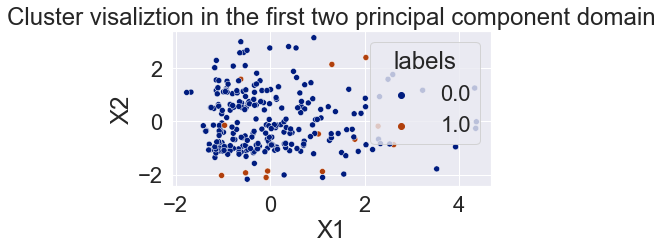

In [5]:
sns.set(font_scale=2)
pca = PCA(n_components=2).fit_transform(X_train.toarray())
df_prim = pd.DataFrame(pca)
df_prim.columns = ['X1', 'X2']
df_prim['labels'] = y_train
ax = sns.scatterplot(x='X1', y='X2', hue='labels', 
    data=df_prim, palette="dark")
ax.set(title="Cluster visaliztion in the first two principal component domain")
plt.tight_layout()
plt.savefig('../images/PCA_before_smoteenn.png')

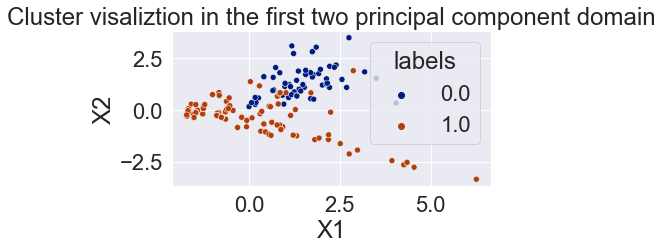

In [6]:
# SMOTEENN
sampling = imblearn.combine.SMOTEENN()
X_smoteenn, y_smoteenn, df_smoteenn = process_smote(X=X_train, y=y_train, sampling=sampling) 
sns.set(font_scale=2)
ax = sns.scatterplot(x='X1', y='X2', hue='labels', 
    data=df_smoteenn, palette="dark")
ax.set(title="Cluster visaliztion in the first two principal component domain")
plt.tight_layout()
plt.savefig('../images/PCA_after_smoteenn.png')


In [7]:
def custom_metric(A, B):
    d = pd.DataFrame(classification_report(A, B, digits=2,
                                        output_dict=True)).T
    d = d.to_dict()
    d['roc auc'] = roc_auc_score(A, B)
    return d

In [8]:
def process_lazypredict(X_train=None, y_train=None, X_test=None, y_test=None):
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=custom_metric)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    return models

In [9]:
X_test.toarray().shape

(92, 1657)

In [10]:
X_smoteenn.toarray().shape

(326, 1657)

In [11]:
y_test.shape

(92,)

In [12]:
models_smoteenn = process_lazypredict(X_train=X_smoteenn.toarray(), 
    y_train=y_smoteenn, X_test=X_test.toarray(), y_test=y_test)

100%|██████████| 30/30 [00:03<00:00,  9.49it/s]


In [13]:
models_smoteenn

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,custom_metric,Time Taken
Model,,,,,,
DecisionTreeClassifier,0.68,0.83,0.83,0.77,"{'precision': {'0.0': 1.0, '1.0': 0.1470588235...",0.05
ExtraTreeClassifier,0.75,0.77,0.77,0.82,"{'precision': {'0.0': 0.9848484848484849, '1.0...",0.04
LinearDiscriminantAnalysis,0.54,0.76,0.76,0.66,"{'precision': {'0.0': 1.0, '1.0': 0.1063829787...",0.15
LogisticRegression,0.50,0.74,0.74,0.62,"{'precision': {'0.0': 1.0, '1.0': 0.0980392156...",0.05
BaggingClassifier,0.66,0.73,0.73,0.75,"{'precision': {'0.0': 0.9827586206896551, '1.0...",0.09
RandomForestClassifier,0.64,0.72,0.72,0.74,"{'precision': {'0.0': 0.9821428571428571, '1.0...",0.17
SGDClassifier,0.74,0.67,0.67,0.81,"{'precision': {'0.0': 0.9701492537313433, '1.0...",0.06
Perceptron,0.72,0.66,0.66,0.79,"{'precision': {'0.0': 0.9692307692307692, '1.0...",0.05
NearestCentroid,0.52,0.65,0.65,0.64,"{'precision': {'0.0': 0.9777777777777777, '1.0...",0.04


In [14]:
models_smoteenn['Precision_0'] = models_smoteenn['custom_metric'].apply(lambda x: x['precision']['0.0'])
models_smoteenn['Precision_1'] = models_smoteenn['custom_metric'].apply(lambda x: x['precision']['1.0'])
models_smoteenn['Recall_0'] = models_smoteenn['custom_metric'].apply(lambda x: x['recall']['0.0'])
models_smoteenn['Recall_1'] = models_smoteenn['custom_metric'].apply(lambda x: x['recall']['1.0'])
models_smoteenn['F1_0'] = models_smoteenn['custom_metric'].apply(lambda x: x['f1-score']['0.0'])
models_smoteenn['F1_1'] = models_smoteenn['custom_metric'].apply(lambda x: x['f1-score']['1.0'])
models_smoteenn['ROC_AUC'] = models_smoteenn['custom_metric'].apply(lambda x: x['roc auc'])
models_smoteenn.drop('custom_metric', axis=1, inplace=True)
models_smoteenn

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken,Precision_0,Precision_1,Recall_0,Recall_1,F1_0,F1_1,ROC_AUC
Model,,,,,,,,,,,,
DecisionTreeClassifier,0.68,0.83,0.83,0.77,0.05,1.00,0.15,0.67,1.00,0.80,0.26,0.83
ExtraTreeClassifier,0.75,0.77,0.77,0.82,0.04,0.98,0.15,0.75,0.80,0.85,0.26,0.77
LinearDiscriminantAnalysis,0.54,0.76,0.76,0.66,0.15,1.00,0.11,0.52,1.00,0.68,0.19,0.76
LogisticRegression,0.50,0.74,0.74,0.62,0.05,1.00,0.10,0.47,1.00,0.64,0.18,0.74
BaggingClassifier,0.66,0.73,0.73,0.75,0.09,0.98,0.12,0.66,0.80,0.79,0.21,0.73
RandomForestClassifier,0.64,0.72,0.72,0.74,0.17,0.98,0.11,0.63,0.80,0.77,0.20,0.72
SGDClassifier,0.74,0.67,0.67,0.81,0.06,0.97,0.12,0.75,0.60,0.84,0.20,0.67
Perceptron,0.72,0.66,0.66,0.79,0.05,0.97,0.11,0.72,0.60,0.83,0.19,0.66
NearestCentroid,0.52,0.65,0.65,0.64,0.04,0.98,0.09,0.51,0.80,0.67,0.15,0.65


In [15]:
models_smoteenn[['Precision_0', 'Precision_1', 'Recall_0', 'Recall_1', 'F1_0', 'F1_1', 'ROC AUC']].head(5).style.background_gradient(cmap='PuBu')

,Precision_0,Precision_1,Recall_0,Recall_1,F1_0,F1_1,ROC AUC
Model,,,,,,,
DecisionTreeClassifier,1.00,0.15,0.67,1.00,0.80,0.26,0.83
ExtraTreeClassifier,0.98,0.15,0.75,0.80,0.85,0.26,0.77
LinearDiscriminantAnalysis,1.00,0.11,0.52,1.00,0.68,0.19,0.76
LogisticRegression,1.00,0.10,0.47,1.00,0.64,0.18,0.74
BaggingClassifier,0.98,0.12,0.66,0.80,0.79,0.21,0.73


In [16]:
models_smoteenn

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken,Precision_0,Precision_1,Recall_0,Recall_1,F1_0,F1_1,ROC_AUC
Model,,,,,,,,,,,,
DecisionTreeClassifier,0.68,0.83,0.83,0.77,0.05,1.00,0.15,0.67,1.00,0.80,0.26,0.83
ExtraTreeClassifier,0.75,0.77,0.77,0.82,0.04,0.98,0.15,0.75,0.80,0.85,0.26,0.77
LinearDiscriminantAnalysis,0.54,0.76,0.76,0.66,0.15,1.00,0.11,0.52,1.00,0.68,0.19,0.76
LogisticRegression,0.50,0.74,0.74,0.62,0.05,1.00,0.10,0.47,1.00,0.64,0.18,0.74
BaggingClassifier,0.66,0.73,0.73,0.75,0.09,0.98,0.12,0.66,0.80,0.79,0.21,0.73
RandomForestClassifier,0.64,0.72,0.72,0.74,0.17,0.98,0.11,0.63,0.80,0.77,0.20,0.72
SGDClassifier,0.74,0.67,0.67,0.81,0.06,0.97,0.12,0.75,0.60,0.84,0.20,0.67
Perceptron,0.72,0.66,0.66,0.79,0.05,0.97,0.11,0.72,0.60,0.83,0.19,0.66
NearestCentroid,0.52,0.65,0.65,0.64,0.04,0.98,0.09,0.51,0.80,0.67,0.15,0.65


In [17]:
fig = px.bar(models_smoteenn.reset_index(), x='Model', y='ROC AUC', color='Model', color_discrete_sequence=px.colors.qualitative.Dark24_r)
fig.show()

Based on the performance of different models with default hyperparameters, we decided to perform hyperparameter optimization of AdaBoostClassifier, DecisionTreeClassifier, LGBMClassifier, and XGBClassifier.

Hyperparametr to optimize:

AdaBoostClassifier (GridSearchCV): learning_rate (1), n_estimators (50), base_estimator (DecisionTreeClassifier(max_depth=1))

DecisionTreeClassifier (GridSearchCV): max_depth (None), min_samples_split (2), max_features (None) 

XGBClassifier: n_estimators, max_depth, reg_alpha, reg_lambda, eta, gamma, subsample, colsample_bytree

<!---
LightGBM: num_boost_round, num_leaves, max_depth, lambda_l2, lambda_l1, min_child_samples, min_data_in_leaf
--->

In [18]:
X_train=X_smoteenn.toarray()
y_train=y_smoteenn
X_test=X_test.toarray()
y_test=y_test

In [19]:
# AdaBoostClassifier

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'Precision': make_scorer(precision_score), 'Recall': make_scorer(recall_score)}

param_grid = {
    'learning_rate': np.arange(0, 1.1, 0.2),
    'n_estimators': np.arange(0, 205, 50),
    #'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]
}

ada = AdaBoostClassifier(random_state=42)

gs_ada = GridSearchCV(estimator=ada, 
                      param_grid=param_grid,
                      scoring=scoring,
                      refit='AUC',
                      return_train_score=True,
                      cv=3)
gs_ada.fit(X_train, y_train)
y_pred = gs_ada.predict(X_test)

print('Accuracy for optimized ada: {}'.format(accuracy_score(y_test, y_pred)))
print('F1 score for optimized ada: {}'.format(f1_score(y_test, y_pred)))
print('ROC AUC for optimized ada: {}'.format(roc_auc_score(y_test, y_pred)))


Accuracy for optimized ada: 0.6304347826086957
F1 score for optimized ada: 0.15
ROC AUC for optimized ada: 0.6160919540229886


In [20]:
ada_results = gs_ada.cv_results_
gs_ada.best_params_

{'learning_rate': 0.8, 'n_estimators': 100}

In [21]:
gs_ada_df = pd.DataFrame()
for k in param_grid:
    gs_ada_df[k] = ada_results['param_' + k]

for k in ['Accuracy', 'Precision', 'AUC', 'Recall']:
    gs_ada_df['mean_train_' + k] = ada_results['mean_train_' + k]
    gs_ada_df['std_train_' + k] = ada_results['std_train_' + k]
    gs_ada_df['mean_test_' + k] = ada_results['mean_test_' + k]
    gs_ada_df['std_test_' + k] = ada_results['std_test_' + k]


In [22]:
#gs_ada_df['max_depth'] = gs_ada_df['base_estimator'].apply(lambda x: x.max_depth)

In [23]:
gs_ada_df = gs_ada_df[gs_ada_df['learning_rate'] == 0.8]
#gs_ada_df = gs_ada_df[gs_ada_df['max_depth'] == 2]
gs_ada_df

,learning_rate,n_estimators,mean_train_Accuracy,std_train_Accuracy,mean_test_Accuracy,std_test_Accuracy,mean_train_Precision,std_train_Precision,mean_test_Precision,std_test_Precision,mean_train_AUC,std_train_AUC,mean_test_AUC,std_test_AUC,mean_train_Recall,std_train_Recall,mean_test_Recall,std_test_Recall
20,0.8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,0.8,50,1.00,0.00,0.97,0.02,1.00,0.00,0.98,0.00,1.00,0.00,0.99,0.01,1.00,0.00,0.98,0.02
22,0.8,100,1.00,0.00,0.97,0.02,1.00,0.00,0.97,0.00,1.00,0.00,1.00,0.01,1.00,0.00,0.98,0.02
23,0.8,150,1.00,0.00,0.97,0.02,1.00,0.00,0.98,0.00,1.00,0.00,1.00,0.01,1.00,0.00,0.98,0.02
24,0.8,200,1.00,0.00,0.97,0.02,1.00,0.00,0.98,0.00,1.00,0.00,1.00,0.01,1.00,0.00,0.98,0.02


In [24]:
fig = go.Figure([
    go.Scatter(
        name='test_auc',
        x=gs_ada_df['n_estimators'],
        y=gs_ada_df['mean_test_AUC'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    go.Scatter(
        x=gs_ada_df['n_estimators'],
        y=gs_ada_df['mean_test_AUC']+gs_ada_df['std_test_AUC'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        x=gs_ada_df['n_estimators'],
        y=gs_ada_df['mean_test_AUC']-gs_ada_df['std_test_AUC'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
])
fig.update_layout(
    yaxis_title='Score',
    title='GridSearchCV for n_estimators',
    hovermode="x"
)
fig.show()

In [25]:
# DecisionTreeClassifier

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'Precision': make_scorer(precision_score), 'Recall': make_scorer(recall_score)}

param_grid = {
    'max_depth': [None, 2, 4, 6, 8],
    'min_samples_split': [2, 10, 25, 50],
    'max_features': [None, 'log2', 'sqrt']
}

dtc = DecisionTreeClassifier(random_state=42)

gs_dtc = GridSearchCV(estimator=dtc, 
                      param_grid=param_grid,
                      scoring=scoring,
                      refit='AUC',
                      return_train_score=True,
                      cv=3)
gs_dtc.fit(X_train, y_train)
y_pred = gs_dtc.predict(X_test)

print('Accuracy for optimized ada: {}'.format(accuracy_score(y_test, y_pred)))
#print('F1 score for optimized ada: {}'.format(f1_score(y_test, y_pred)))
print('ROC AUC for optimized ada: {}'.format(roc_auc_score(y_test, y_pred)))

Accuracy for optimized ada: 0.6847826086956522
ROC AUC for optimized ada: 0.8333333333333334


In [26]:
def xgb_classifier(n_estimators, max_depth, reg_alpha,
                   reg_lambda, eta, subsample, colsample_bytree,
                   gamma):
    params = {"booster": 'gbtree',
              "objective" : "binary:logistic",
              "eval_metric" : "auc", 
              "is_unbalance": True,
              "n_estimators": int(n_estimators),
              "max_depth" : int(max_depth),
              "reg_alpha" : reg_alpha,
              "reg_lambda" : reg_lambda,
              "gamma": gamma,
              "num_threads" : 20,
              "subsample" : subsample,
              "learning_rate" : 0.01,
              "subsample_freq" : 5,
              "seed" : 42,
              "verbosity" : 0,
              "colsmaple_bytree": colsample_bytree}
    train_data = xgboost.DMatrix(X_train, y_train)
    cv_result = xgboost.cv(params,
                       train_data,
                       1000,
                       early_stopping_rounds=100,
                       stratified=True,
                       nfold=3)
    return cv_result['test-auc-mean'].iloc[-1]

In [27]:
xgbBO = BayesianOptimization(f=xgb_classifier, pbounds={"n_estimators": (10, 100),
                                                'max_depth': (2, 40),
                                                'reg_alpha': (0.0, 1.0),
                                                'reg_lambda': (0.0, 1.0),
                                                'subsample': (0.0, 1.0),
                                                'colsample_bytree': (0.0, 1.0),
                                                "gamma": (0, 10),
                                                "eta": (0.0, 1.0)
                                                })

xgbBO.maximize(n_iter=20, init_points=2)

|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9878   |  0.00291  |  0.7195   |  8.691    |  23.91    |  91.19    |  0.3118   |  0.3619   |  0.7879   |
|  2        |  0.9844   |  0.06204  |  0.4639   |  0.7938   |  11.89    |  53.72    |  0.6338   |  0.2443   |  0.1962   |
|  3        |  0.9474   |  0.3386   |  0.2239   |  9.353    |  24.46    |  91.05    |  0.3415   |  0.7163   |  0.08127  |
|  4        |  0.9512   |  0.2027   |  0.2274   |  8.682    |  7.165    |  58.87    |  0.4814   |  0.5223   |  0.09823  |
|  5        |  0.9928   |  0.3406   |  0.7908   |  1.773    |  38.04    |  17.09    |  0.8838   |  0.9159   |  0.7425   |
|  6        |  0.9919   |  0.9751   |  0.8489   |  4.213    |  19.53    |  52.96    |  0.196    |  0.4506   |  0.9305   |
|  7        |  0.9903   

In [28]:
xgbBO.max

{'target': 0.9951983333333333,
 'params': {'colsample_bytree': 0.15206473814751942,
  'eta': 0.33001477043207283,
  'gamma': 0.8719204838770422,
  'max_depth': 20.410937429314657,
  'n_estimators': 94.3134633483094,
  'reg_alpha': 0.5857428507722843,
  'reg_lambda': 0.35033864951132676,
  'subsample': 0.7137544942822505}}

In [29]:
train_data = xgboost.DMatrix(X_train, y_train)
params = xgbBO.max['params']
params['objective'] = 'binary:logistic'
params['max_depth'] = 10
params['n_estimators'] = 80
xgb_opt = xgboost.train(dtrain=train_data,
                          params=params,
                          #early_stopping_rounds=100,
                          num_boost_round=1000)

In [30]:
y_pred = xgb_opt.predict(xgboost.DMatrix(X_test))

#print('Accuracy for optimized ada: {}'.format(accuracy_score(y_test, y_pred)))
#print('F1 score for optimized ada: {}'.format(f1_score(y_test, y_pred)))
print('ROC AUC for optimized ada: {}'.format(roc_auc_score(y_test, y_pred)))

ROC AUC for optimized ada: 0.6643678160919539
